# Facial Landmark Prediction Model Training

This notebook documents the process of training a model to predict head pose angles (pitch, yaw, roll) based on facial landmark data extracted from images. The steps include loading the dataset, cleaning it, normalizing the features, splitting the data, training a model, and evaluating its performance.

## 1. Load the Cleaned Dataset

In this section, we load the cleaned dataset containing facial landmark coordinates and head pose angles from a CSV file. The first few rows of the dataset are displayed to get an overview of its structure.

In [2]:
import pandas as pd

# Load the cleaned dataset
data_path = './data/poses.csv'
df = pd.read_csv(data_path)

# Display the first few rows of the dataset
df.head()

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.489194,0.639722,0.521101,0.295806,0.354743,0.441597,0.403753,0.680927,0.481321,0.807920,0.669544,0.473942,0.574203,0.702994,-0.399231,0.018227,0.085676
1,0.401499,0.604184,0.475316,0.344523,0.408574,0.481754,0.421570,0.668330,0.447475,0.764491,0.605816,0.506940,0.523344,0.691370,0.470065,1.189533,0.300959
2,0.445534,0.621876,0.443547,0.373616,0.424176,0.508653,0.480120,0.683903,0.528819,0.769280,0.586251,0.500861,0.582848,0.679839,-0.184650,0.881137,-0.236852
3,0.467992,0.648420,0.407912,0.370758,0.354222,0.524016,0.463581,0.699305,0.551854,0.780015,0.605186,0.467229,0.604576,0.666296,-0.175379,0.299208,-0.373374
4,0.372060,0.621196,0.395060,0.392921,0.397376,0.513964,0.433618,0.697691,0.467873,0.773994,0.525802,0.498256,0.508779,0.698543,-0.882169,1.198004,-1.033374


## 2. Data Cleaning

### 2.1 Remove Duplicates
We remove any duplicate rows from the dataset to ensure the integrity of the data used for training.

In [3]:
# Remove duplicates
df.drop_duplicates(inplace=True)

### 2.2 Check for Missing Values
Here, we check for any missing values in the dataset and print the count for each column. Rows with missing values are then dropped from the dataset to maintain a complete dataset for training.

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Remove rows with missing values
df.dropna(inplace=True)  # Alternatively, you could use imputation

Missing values in each column:
 nose_x           208
nose_y           208
forehead_x       208
forehead_y       208
left_eye_x       208
left_eye_y       208
mouth_left_x     208
mouth_left_y     208
chin_x           208
chin_y           208
right_eye_x      208
right_eye_y      208
mouth_right_x    208
mouth_right_y    208
pitch              0
yaw                0
roll               0
dtype: int64


## 3. Normalization of Features
In this section, we define a normalization function that centers the facial landmark coordinates around the nose and scales them relative to the distance between the mouth corners and the eyes. The normalized dataset is then displayed.

In [5]:
def normalize(poses_df):
    """
    Normalize facial landmark coordinates around the nose and scale them.

    Parameters:
    - poses_df (DataFrame): DataFrame containing landmark coordinates.

    Returns:
    - DataFrame: Normalized coordinates.
    
    Raises:
    - ValueError: If required columns are missing in the DataFrame.
    - ZeroDivisionError: If scaling results in division by zero.
    """
    
    # Define the landmark features to be normalized
    features = ['forehead_', 'nose_', 'mouth_left_', 'mouth_right_', 'left_eye_', 'chin_', 'right_eye_']
    
    # Check if required columns are present in the DataFrame
    for dim in ['x', 'y']:
        for feature in features:
            if f'{feature}{dim}' not in poses_df.columns:
                raise ValueError(f"Missing column: {feature}{dim}")

    normalized_df = poses_df.copy()
    
    for dim in ['x', 'y']:
        # Centering around the nose 
        nose_col = f'nose_{dim}'
        for feature in features:
            normalized_df[f'{feature}{dim}'] = poses_df[f'{feature}{dim}'] - poses_df[nose_col]
        
        # Calculate the scaling factor
        left_eye_col = f'left_eye_{dim}'
        mouth_right_col = f'mouth_right_{dim}'
        mouth_left_col = f'mouth_left_{dim}'

        # Check for zero division risk
        diff = normalized_df[mouth_right_col] - normalized_df[left_eye_col]
        if (diff == 0).any():
            raise ZeroDivisionError("Scaling factor resulted in division by zero for some entries.")

        # Scaling
        for feature in features:
            normalized_df[f'{feature}{dim}'] = normalized_df[f'{feature}{dim}'] / diff
    
    return normalized_df


In [6]:
# Normalize the dataset
normalized_df = normalize(df)

# Display the first few rows of the normalized dataset
normalized_df.head()

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.0,0.0,0.145389,-1.315685,-0.612647,-0.757945,-0.389327,0.157636,-0.035876,0.643461,0.821789,-0.634208,0.387353,0.242055,-0.399231,0.018227,0.085676
1,0.0,0.0,0.643168,-1.238742,0.061645,-0.584067,0.174874,0.306017,0.400586,0.764764,1.780222,-0.463914,1.061645,0.415933,0.470065,1.189533,0.300959
2,0.0,0.0,-0.012524,-1.450241,-0.134608,-0.661405,0.217967,0.362334,0.524888,0.861074,0.886842,-0.706921,0.865392,0.338595,-0.184650,0.881137,-0.236852
3,0.0,0.0,-0.239980,-1.951528,-0.454436,-0.874364,-0.017618,0.357641,0.334972,0.924901,0.547998,-1.273491,0.545564,0.125636,-0.175379,0.299208,-0.373374
4,0.0,0.0,0.206458,-1.236728,0.227247,-0.580952,0.552568,0.414430,0.860054,0.827818,1.380055,-0.666052,1.227247,0.419048,-0.882169,1.198004,-1.033374


In [7]:
normalized_df.shape

(1792, 17)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## 4. Data Splitting
The dataset is divided into features (X) and targets (y), where the targets are the head pose angles (pitch, yaw, roll). The data is then split into training, validation, and test sets to evaluate the model's performance effectively.

In [9]:
# Split the data into features and target
X = normalized_df.drop(['pitch', 'yaw', 'roll'], axis=1)
y = normalized_df[['pitch', 'yaw', 'roll']]

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## 5. Model Definition
A Random Forest Regressor model is defined with 100 trees. This model is chosen for its robustness and ability to handle complex datasets.

In [11]:
# Define the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

## 6. Hyperparameter Tuning
We use grid search to find the best hyperparameters for the Random Forest model. This process evaluates multiple combinations of hyperparameters using cross-validation and selects the best-performing model based on mean squared error.

In [12]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

## 7. Model Training
The best model obtained from grid search is then trained on the training dataset.

In [13]:
# Train the best model
best_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=10, n_estimators=200, random_state=42)

In [20]:
import joblib

# Save the trained model to a file
model_filename = './data/m_hpe.pkl'  # Specify your desired filename
joblib.dump(best_model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to ./data/m_hpe.pkl


In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Assuming best_model is your trained model, and X_val, y_val are your validation features and targets
# Make predictions on validation set
y_val_pred = best_model.predict(X_val)

# Calculate evaluation metrics
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100  # MAPE in percentage

# Create a DataFrame to hold the evaluation metrics
metrics = {
    'Metric': ['MSE', 'R²', 'MAE', 'MAPE (%)'],
    'Value': [mse, r2, mae, mape]
}

metrics_df = pd.DataFrame(metrics)

# Display the metrics DataFrame
metrics_df.style.set_caption("Model Evaluation Metrics")

NameError: name 'best_model' is not defined

In [11]:
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Step 1: Load the saved model
model_filename = './data/m_hpe.pkl'  # Specify your model filename
loaded_model = joblib.load(model_filename)
print("Model loaded successfully.")

# Step 2: Make predictions on the test set
y_test_pred = loaded_model.predict(X_test)

# Step 3: Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100  # MAPE in percentage

# Create a DataFrame to hold the evaluation metrics
metrics = {
    'Metric': ['MSE', 'R²', 'MAE', 'MAPE (%)'],
    'Value': [mse_test, r2_test, mae_test, mape_test]
}

metrics_df = pd.DataFrame(metrics)

# Display the metrics DataFrame
metrics_df.style.set_caption("Model Evaluation Metrics")


Model loaded successfully.


,Metric,Value
0,MSE,0.033886
1,R²,0.676866
2,MAE,0.113436
3,MAPE (%),179.591885


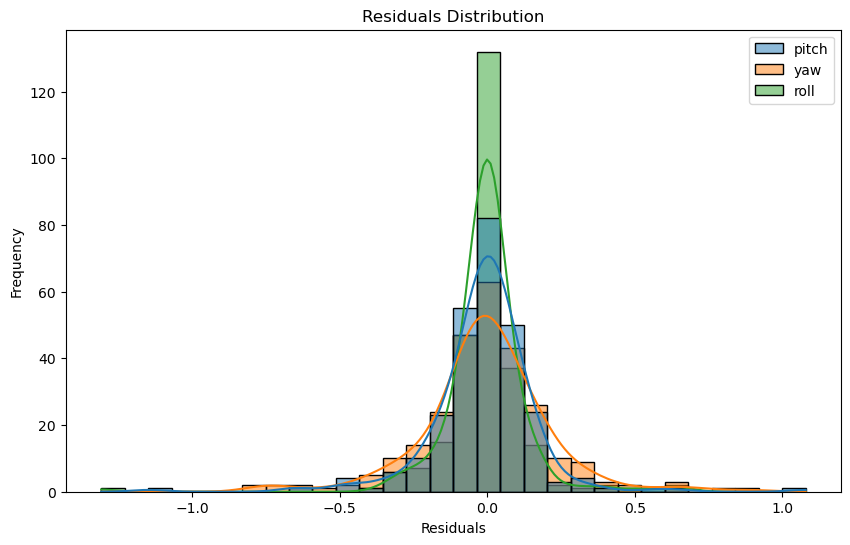

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


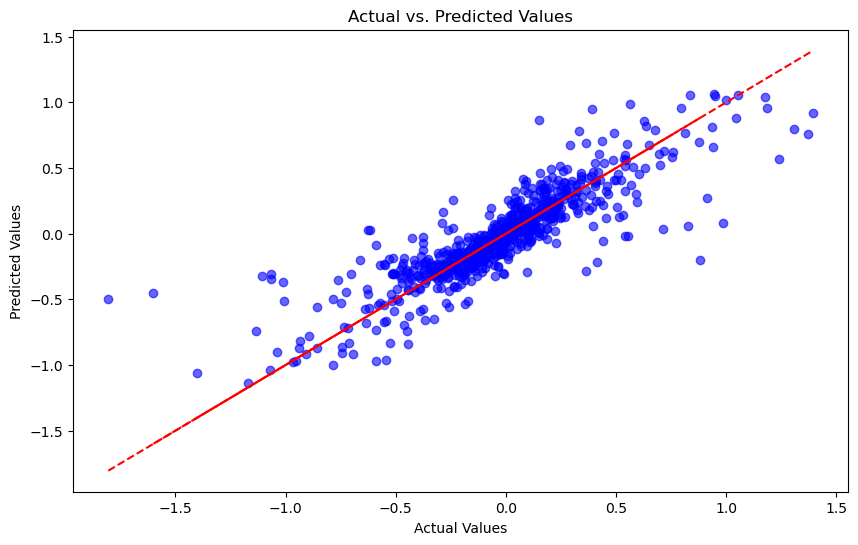

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()


C:\Users\Khizar\AppData\Local\Temp\ipykernel_7724\1501827455.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=angles, y=mape_per_angle, palette='viridis')


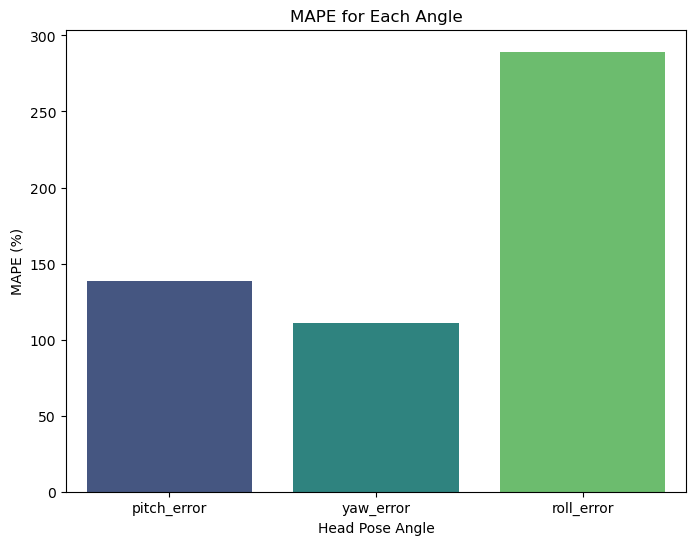

In [19]:
mape_per_angle = 100 * np.mean(np.abs((y_test - y_test_pred) / y_test), axis=0)

plt.figure(figsize=(8, 6))
sns.barplot(x=angles, y=mape_per_angle, palette='viridis')
plt.title("MAPE for Each Angle")
plt.xlabel("Head Pose Angle")
plt.ylabel("MAPE (%)")
plt.show()
